
Optimized Parameters:
{'intercept': 0.0, 'TV': {'beta': 1016.9814795254832, 'adstock_rate': 0.9990724388864317, 'hill_k': 2.9999788012883117, 'hill_s': 0.5004749416311415}, 'Digital': {'beta': 0.0, 'adstock_rate': 0.6365762456005085, 'hill_k': 3.0, 'hill_s': 0.5}, 'Search': {'beta': 13.250879104585866, 'adstock_rate': 1.0, 'hill_k': 2.999999994871275, 'hill_s': 0.5000002220295284}}

RMSE: 49.18
R-squared: 0.0117


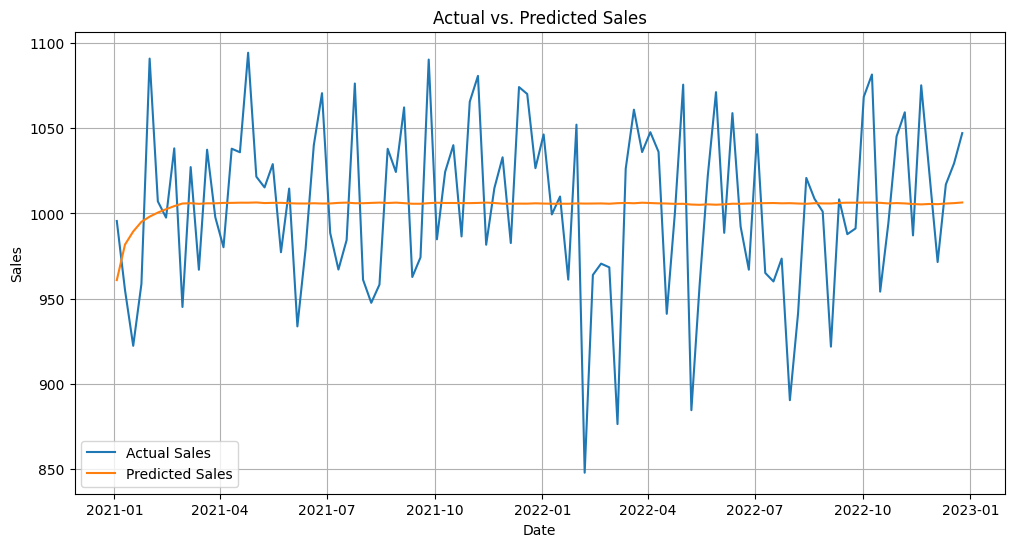

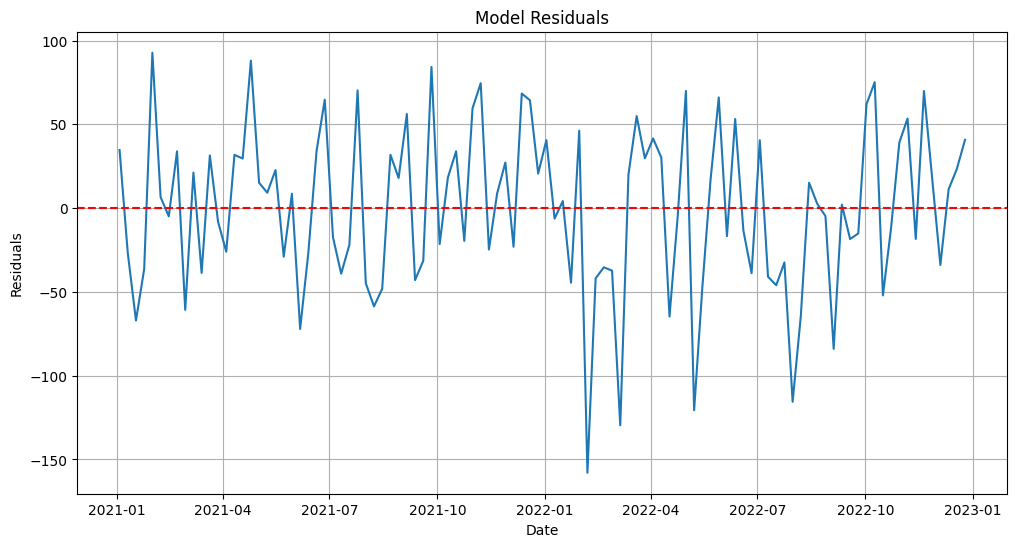


Channel Contributions (first 5 rows):
           TV  Digital     Search
0  949.581729      0.0  11.295807
1  969.901167      0.0  11.848426
2  977.320141      0.0  12.108330
3  982.837797      0.0  12.246929
4  985.789577      0.0  12.345650


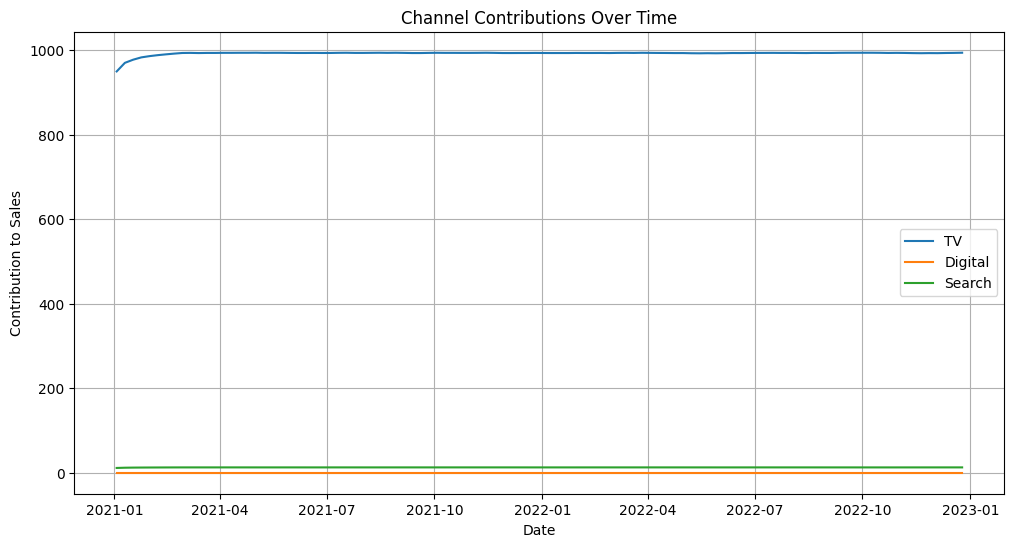


Optimal Budget Allocation:
TV: 1248.92
Digital: 0.00
Search: 0.00
Projected Sales: 1007.47

Equal Budget Allocation:
TV: 416.31
Digital: 416.31
Search: 416.31
Projected Sales (Equal Allocation): 1005.91


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random

# --- Lightweight Marketing Mix Model (Lightweight MMM) ---

class LightweightMMM:
    """
    A simplified Marketing Mix Model (MMM) implementation.  This focuses on
    core principles: adstock, saturation, and optimization, suitable for
    smaller datasets and faster iteration.  It does *not* include all features
    of a production-ready MMM (e.g., trend, seasonality, hierarchical
    priors).  This is a key difference from libraries like Robyn, which are
    designed for more comprehensive, Bayesian MMMs.

    Args:
        data (pd.DataFrame): Input data.  Must contain 'date' and 'sales'
            columns, and columns for each media channel.  Dates should ideally
            be weekly, but daily data is also acceptable (adjust adstock
            accordingly).
        media_cols (list):  List of column names representing media channels.
        adstock_max_lag (int): Maximum lag (in periods, e.g., weeks) for
            adstock effect.  A reasonable starting point is 8-12 weeks.
        saturation_method (str):  "hill" (recommended) or "exponential".  "hill"
            is generally preferred for its flexibility.
        hill_k_bounds (tuple): Bounds for the 'k' parameter (half-saturation
            point) in the Hill function.  A wider range allows more flexibility
            but may increase optimization difficulty.
        hill_s_bounds (tuple): Bounds for the 's' parameter (slope) in the Hill
            function.
        optimize_adstock (bool): Whether to optimize adstock parameters.  If
            False, uses a fixed adstock rate.
        adstock_rate (float):  The fixed adstock retention rate if
            optimize_adstock is False.  Must be between 0 and 1.
        random_seed (int, optional): Random seed for reproducibility.

    Attributes:
        params (dict): Optimized parameters for each channel, including adstock
            and saturation parameters.
        predictions (pd.Series): Predicted sales based on the model.
        residuals (pd.Series):  Difference between actual and predicted sales.
    """

    def __init__(self, data, media_cols, adstock_max_lag=8,
                 saturation_method='hill',
                 hill_k_bounds=(0.1, 5), hill_s_bounds=(0.1, 3),
                 optimize_adstock=True, adstock_rate=0.7, random_seed=42):

        self.data = data.copy()
        self.media_cols = media_cols
        self.adstock_max_lag = adstock_max_lag
        self.saturation_method = saturation_method
        self.hill_k_bounds = hill_k_bounds
        self.hill_s_bounds = hill_s_bounds
        self.optimize_adstock = optimize_adstock
        self.adstock_rate = adstock_rate
        self.random_seed = random_seed

        # --- Input Validation ---
        if not isinstance(self.data, pd.DataFrame):
            raise TypeError("Input data must be a pandas DataFrame.")
        if 'date' not in self.data.columns or 'sales' not in self.data.columns:
            raise ValueError("Data must contain 'date' and 'sales' columns.")
        if not all(col in self.data.columns for col in self.media_cols):
            raise ValueError("Not all media columns found in data.")
        if not 0 <= self.adstock_rate <= 1:
            raise ValueError("adstock_rate must be between 0 and 1.")

        self.data['date'] = pd.to_datetime(self.data['date'])
        self.data.sort_values('date', inplace=True)
        self.data.reset_index(drop=True, inplace=True)
        random.seed(self.random_seed)
        np.random.seed(self.random_seed)  # Ensure numpy uses the seed

        # --- Initialization ---
        self.params = {}
        self.predictions = None
        self.residuals = None
        self._optimize()


    def _adstock(self, x, rate, max_lag):
        """
        Calculates the adstock effect of a media channel.

        Args:
            x (np.ndarray): Time series of media spend/impressions.
            rate (float): Retention rate.
            max_lag (int): Maximum lag.

        Returns:
            np.ndarray: Time series with adstock applied.
        """
        lags = np.arange(max_lag + 1)
        weights = rate**lags
        # Key change: Use np.convolve for efficient adstock calculation.
        return np.convolve(x, weights, mode='full')[:len(x)]


    def _saturation(self, x, k, s, method='hill'):
        """
        Applies a saturation function to the media spend.

        Args:
            x (np.ndarray):  Media spend (or adstocked spend).
            k (float): Half-saturation point (Hill function).
            s (float): Slope (Hill function).
            method (str): "hill" or "exponential".

        Returns:
            np.ndarray: Saturated media spend.
        """
        if method == 'hill':
            return x**s / (k**s + x**s)  # Hill function
        elif method == 'exponential':
            return 1 - np.exp(-k * x)   # Exponential decay
        else:
            raise ValueError("Invalid saturation method. Choose 'hill' or 'exponential'.")


    def _mmm_equation(self, params_array, data):
        """
        The core MMM equation.  Calculates predicted sales given parameters.

        Args:
            params_array (np.ndarray):  Flattened array of parameters.  Must
                be structured correctly.
            data (pd.DataFrame): Input data.

        Returns:
            np.ndarray: Predicted sales.
        """

        # --- Parameter Extraction ---
        idx = 0
        intercept = params_array[idx]
        idx += 1
        beta_media = []
        adstock_rates = {}
        hill_k = {}
        hill_s = {}

        for ch in self.media_cols:
            beta_media.append(params_array[idx])
            idx += 1

            if self.optimize_adstock:
                adstock_rates[ch] = params_array[idx]
                idx += 1
            else:
                adstock_rates[ch] = self.adstock_rate

            if self.saturation_method == 'hill':
                hill_k[ch] = params_array[idx]
                idx += 1
                hill_s[ch] = params_array[idx]
                idx += 1
            else:  # Exponential saturation
                hill_k[ch] = params_array[idx]  # 'k' for exponential decay
                idx += 1

        # --- Core Model Calculation ---
        sales_pred = intercept  # Start with the intercept

        for i, ch in enumerate(self.media_cols):
            transformed_spend = self._adstock(data[ch].values, adstock_rates[ch], self.adstock_max_lag)
            if self.saturation_method == 'hill':
                saturated_spend = self._saturation(transformed_spend, hill_k[ch], hill_s[ch], method='hill')
            else:
                saturated_spend = self._saturation(transformed_spend, hill_k[ch], method='exponential')
            sales_pred += beta_media[i] * saturated_spend
        return sales_pred


    def _objective_function(self, params_array, data):
        """
        Objective function for optimization (Root Mean Squared Error).

        Args:
            params_array (np.ndarray): Flattened array of parameters.
            data (pd.DataFrame): Input data.

        Returns:
            float: RMSE.
        """
        sales_pred = self._mmm_equation(params_array, data)
        rmse = np.sqrt(np.mean((data['sales'].values - sales_pred)**2))
        return rmse


    def _optimize(self):
        """
        Optimizes the model parameters using scipy.optimize.minimize.
        """

        # --- Parameter Initialization and Bounds ---
        #  Initialize parameters randomly within reasonable bounds
        initial_params = []
        bounds = []

        # Intercept
        initial_params.append(np.random.uniform(0.5 * self.data['sales'].mean(), 1.5 * self.data['sales'].mean())) # reasonable intercept bounds.
        bounds.append((0, None))  # Intercept can't be negative.

        # Media coefficients and saturation parameters
        for ch in self.media_cols:
            # Beta (media coefficient)
            initial_params.append(np.random.uniform(0, 2)) # reasonable initial beta.
            bounds.append((0, None))  # Coefficients should be positive.

            # Adstock rate
            if self.optimize_adstock:
                initial_params.append(np.random.uniform(0.1, 0.9)) # reasonable adstock
                bounds.append((0, 1))  # Adstock rate bounds (0-1)

            # Saturation parameters
            if self.saturation_method == 'hill':
                initial_params.append(np.random.uniform(*self.hill_k_bounds)) # Hill k
                bounds.append(self.hill_k_bounds)  # Hill k bounds
                initial_params.append(np.random.uniform(*self.hill_s_bounds)) # Hill s
                bounds.append(self.hill_s_bounds)  # Hill s bounds
            else:  # exponential
                initial_params.append(np.random.uniform(0, 1))  # Exponential k (decay rate)
                bounds.append((0, 1)) # bound the decay rate

        # --- Optimization ---
        result = minimize(
            self._objective_function,
            x0=initial_params,
            args=(self.data,),
            method='L-BFGS-B',  # Robust for bounded problems
            bounds=bounds,
            options={'maxiter': 200, 'disp': False}  # Control iterations, reduce verbosity
        )

        if not result.success:
            print("Warning: Optimization may not have converged.")
            print(result.message)


        # --- Parameter Extraction from Optimization Result ---
        optimized_params = result.x
        idx = 0
        self.params['intercept'] = optimized_params[idx]
        idx += 1
        for ch in self.media_cols:
            self.params[ch] = {}
            self.params[ch]['beta'] = optimized_params[idx]
            idx += 1

            if self.optimize_adstock:
                self.params[ch]['adstock_rate'] = optimized_params[idx]
                idx += 1
            else:
                self.params[ch]['adstock_rate'] = self.adstock_rate

            if self.saturation_method == 'hill':
                self.params[ch]['hill_k'] = optimized_params[idx]
                idx += 1
                self.params[ch]['hill_s'] = optimized_params[idx]
                idx += 1
            else: # exponential
                self.params[ch]['exp_k'] = optimized_params[idx]
                idx += 1

        # --- Store Predictions and Residuals ---
        self.predictions = pd.Series(self._mmm_equation(optimized_params, self.data), index=self.data.index)
        self.residuals = self.data['sales'] - self.predictions

    def get_channel_contributions(self):
        """
        Calculates the contribution of each media channel to predicted sales.
        Returns a dataframe.
        """
        contributions = {}
        for ch in self.media_cols:
            transformed_spend = self._adstock(
                self.data[ch].values,
                self.params[ch]['adstock_rate'],
                self.adstock_max_lag
            )
            if self.saturation_method == 'hill':
                saturated_spend = self._saturation(
                    transformed_spend,
                    self.params[ch]['hill_k'],
                    self.params[ch]['hill_s'],
                    method='hill'
                )
            else:
                saturated_spend = self._saturation(
                    transformed_spend,
                    self.params[ch]['exp_k'],
                    method='exponential'
                )
            contributions[ch] = self.params[ch]['beta'] * saturated_spend

        return pd.DataFrame(contributions, index=self.data.index)


    def plot_predictions(self):
        """
        Plots actual vs. predicted sales.
        """
        plt.figure(figsize=(12, 6))
        plt.plot(self.data['date'], self.data['sales'], label='Actual Sales')
        plt.plot(self.data['date'], self.predictions, label='Predicted Sales')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.title('Actual vs. Predicted Sales')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_residuals(self):
        """
        Plots the residuals of the model.
        """
        plt.figure(figsize=(12, 6))
        plt.plot(self.data['date'], self.residuals, label='Residuals')
        plt.xlabel('Date')
        plt.ylabel('Residuals')
        plt.title('Model Residuals')
        plt.axhline(0, color='red', linestyle='--')  # Add a zero line
        plt.grid(True)
        plt.show()


    def calculate_rmse(self):
        """Calculates and returns the Root Mean Squared Error (RMSE)."""
        return np.sqrt(np.mean(self.residuals**2))

    def calculate_r_squared(self):
        """Calculates and returns the R-squared (coefficient of determination)."""
        ss_res = np.sum(self.residuals**2)
        ss_tot = np.sum((self.data['sales'] - self.data['sales'].mean())**2)
        return 1 - (ss_res / ss_tot)



# --- Example Usage ---
if __name__ == '__main__':
    # Create some sample data
    num_weeks = 104
    dates = pd.date_range(start="2021-01-01", periods=num_weeks, freq="W")
    sales = 1000 + 50 * np.random.randn(num_weeks)  # Base sales + noise

    # Media spend (simulated)
    tv_spend = 500 + 200 * np.random.rand(num_weeks)
    digital_spend = 300 + 150 * np.random.rand(num_weeks)
    search_spend = 100 + 50 * np.random.rand(num_weeks)

    data = pd.DataFrame({
        'date': dates,
        'sales': sales,
        'TV': tv_spend,
        'Digital': digital_spend,
        'Search': search_spend
    })


    # Initialize and run the model
    model = LightweightMMM(
        data=data,
        media_cols=['TV', 'Digital', 'Search'],
        adstock_max_lag=8,
        saturation_method='hill',
        hill_k_bounds=(0.1, 3),
        hill_s_bounds=(0.5, 2),
        optimize_adstock=True,  # Optimize adstock
        random_seed = 42
    )


    # --- Results and Analysis ---
    print("\nOptimized Parameters:")
    print(model.params)

    print(f"\nRMSE: {model.calculate_rmse():.2f}")
    print(f"R-squared: {model.calculate_r_squared():.4f}")

    model.plot_predictions()
    model.plot_residuals()

    # Channel Contributions
    contributions = model.get_channel_contributions()
    print("\nChannel Contributions (first 5 rows):")
    print(contributions.head())

    # Plot contributions
    plt.figure(figsize=(12, 6))
    for channel in contributions.columns:
        plt.plot(data['date'], contributions[channel], label=channel)
    plt.xlabel('Date')
    plt.ylabel('Contribution to Sales')
    plt.title('Channel Contributions Over Time')
    plt.legend()
    plt.grid()
    plt.show()

    # --- Optional:  Simple Optimization Example (Budget Allocation) ---

    def simulate_sales(budget_allocation, model):
        """Simulates sales for a given budget allocation."""
        simulated_data = model.data.copy()
        total_budget = sum(budget_allocation)
        # Check if budget allocation is valid
        if len(budget_allocation) != len(model.media_cols):
            raise ValueError("Length of budget allocation must match the number of media channels.")
        if total_budget <= 0:
            raise ValueError("Total budget must be greater than zero.")
        if any(b < 0 for b in budget_allocation):
            raise ValueError("Budget allocation values cannot be negative.")

        # Apply the new budget allocation to the *most recent* period.  This is a simplification.
        # In a more realistic scenario, you'd project forward.
        for i, channel in enumerate(model.media_cols):
            simulated_data.loc[simulated_data.index[-1], channel] = budget_allocation[i]

        #  Construct a parameters array using the *optimized* parameters.  We're changing the spend,
        #  not the parameters themselves.
        params_array = [model.params['intercept']]
        for ch in model.media_cols:
            params_array.append(model.params[ch]['beta'])
            if model.optimize_adstock:
                params_array.append(model.params[ch]['adstock_rate'])
            if model.saturation_method == 'hill':
                params_array.append(model.params[ch]['hill_k'])
                params_array.append(model.params[ch]['hill_s'])
            else:
                params_array.append(model.params[ch]['exp_k'])

        # Use the _mmm_equation to get the predicted sales for the *entire* dataset,
        # but we only care about the *last* period (the one we modified).
        predicted_sales = model._mmm_equation(np.array(params_array), simulated_data)
        return -predicted_sales[-1]  # Negative because we're minimizing

    # Define constraints (total budget)
    # Correct the indexing error:  Access the last row using iloc
    total_budget = data[['TV', 'Digital', 'Search']].iloc[-1].sum()  # Sum of the last week's spend
    constraints = ({'type': 'eq', 'fun': lambda x:  sum(x) - total_budget})
    # Define bounds (non-negativity)
    bounds = [(0, total_budget) for _ in range(len(model.media_cols))]

    # Initial guess (equal allocation)
    x0 = [total_budget / len(model.media_cols)] * len(model.media_cols)

    # Run optimization.  Note we pass 'model' as an argument!
    result = minimize(simulate_sales, x0, args=(model,), method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        optimal_allocation = result.x
        print("\nOptimal Budget Allocation:")
        for i, channel in enumerate(model.media_cols):
            print(f"{channel}: {optimal_allocation[i]:.2f}")
        print(f"Projected Sales: {-result.fun:.2f}")  # Remember, we negated for minimization

        # Compare to equal allocation:
        equal_allocation = [total_budget / len(model.media_cols)] * len(model.media_cols)
        equal_sales = -simulate_sales(equal_allocation, model)
        print("\nEqual Budget Allocation:")
        for i, channel in enumerate(model.media_cols):
            print(f"{channel}: {equal_allocation[i]:.2f}")
        print(f"Projected Sales (Equal Allocation): {equal_sales:.2f}")

    else:
        print("\nBudget optimization failed.")
        print(result.message)